In [1]:
import numpy as np
import glob, os, copy
import xarray as xr
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, AxesGrid
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
rootdir = '/global/cscratch1/sd/feng045/SAAG/GPM/'
idldir = f'{rootdir}stats_4pyflex/monthly/'
pydir = f'{rootdir}pyflex_test2/stats/monthly/'

start_year = 2018
end_year = 2019

# Create a list of dates in the format 'year-months'
dates = []
for iy in range(start_year, end_year+1, 1):
    dates = dates + [d.strftime('%Y%m') for d in pd.date_range(start=f'{iy}-01', end=f'{iy}-12', freq='MS')]

# Find all files from the list of dates
pyfiles = []
idlfiles = []
pystatsfiles = []
idlstatsfiles = []
for dd in dates:
    pyfiles = pyfiles + sorted(glob.glob(f'{pydir}mcs_rainmap_{dd}*.nc'))
    idlfiles = idlfiles + sorted(glob.glob(f'{idldir}mcs_rainmap_{dd}*.nc'))
    pystatsfiles = pystatsfiles + sorted(glob.glob(f'{pydir}mcs_statsmap_{dd}*.nc'))
    idlstatsfiles = idlstatsfiles + sorted(glob.glob(f'{idldir}mcs_statsmap_{dd}*.nc'))

topfile = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

figdir = f'/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/


In [4]:
idlfiles, idlstatsfiles

(['/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201806.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201807.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201808.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201809.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201810.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201811.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201812.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201901.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201902.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201903.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/stats_4pyflex/monthly/mcs_rainmap_201904.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/st

In [5]:
pyfiles, pystatsfiles

(['/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201806.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201807.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201808.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201809.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201810.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201811.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201812.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201901.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201902.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_201903.nc',
  '/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/stats/monthly/mcs_rainmap_

In [6]:
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re

color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.HGT.squeeze()
landmask = dstop.LANDMASK.squeeze()
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.lon
lat_ter = dstop.lat
dstop

<xarray.Dataset>
Dimensions:   (lat: 690, lon: 480, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon       (lon) float64 278.1 278.2 278.2 278.4 ... 325.7 325.8 325.9 326.0
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (lat, nbnd) float64 ...
    lon_bnds  (lon, nbnd) float64 ...
    gw        (lat) float64 ...
    area      (lat, lon) float64 ...
    HGT       (lat, lon) float32 ...
    LAKEMASK  (lat, lon) float32 ...
    LANDMASK  (lat, lon) float32 ...
    LU_INDEX  (lat, lon) float32 ...
    XTIME     datetime64[ns] ...
Attributes: (12/154)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    history:                         Wed Jun  9 11:51:55 2021: ncks -O -t 1 -...
    remap_script:                    ncremap
    remap_hostname:                  cori04
    remap_version:                   4.7.9
    map_file:                        weight_wrf_imerg_conserve.nc
    input_file:                      /global/cscratch1/sd/feng045/SAAG/map_da...

In [8]:
dspy = xr.open_mfdataset(pyfiles, concat_dim='time', combine='nested')
lon = dspy.lon
lat = dspy.lat
dspy.load()

<xarray.Dataset>
Dimensions:                  (lat: 690, lon: 480, time: 13)
Coordinates:
  * time                     (time) datetime64[ns] 2018-06-01 ... 2019-06-01
  * lat                      (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * lon                      (lon) float32 -81.95 -81.85 ... -34.15 -34.05
Data variables:
    precipitation            (time, lat, lon) float32 181.5 175.8 ... 0.0412
    mcs_precipitation        (time, lat, lon) float32 6.057 10.6 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 2.0 4.0 4.0 ... 0.0 0.0
    ntimes                   (time) int32 720 744 744 720 ... 744 720 744 719
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Fri Feb 11 15:57:59 2022

In [9]:
dspystats = xr.open_mfdataset(pystatsfiles, concat_dim='time', combine='nested')
dspystats.load()

<xarray.Dataset>
Dimensions:              (lat: 690, lon: 480, percentiles: 4, time: 13)
Coordinates:
  * lon                  (lon) float32 -81.95 -81.85 -81.75 ... -34.15 -34.05
  * lat                  (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * percentiles          (percentiles) int32 50 75 90 95
  * time                 (time) datetime64[ns] 2018-06-01 ... 2019-06-01
Data variables: (12/21)
    mcs_number_ccs       (time, lat, lon) float32 5.0 5.0 5.0 ... 0.0 0.0 0.0
    mcs_number_pf        (time, lat, lon) float32 5.0 5.0 5.0 ... 0.0 0.0 0.0
    mcs_nhour_ccs        (time, lat, lon) float32 31.0 33.0 33.0 ... 0.0 0.0 0.0
    mcs_nhour_pf         (time, lat, lon) float32 15.0 17.0 17.0 ... 0.0 0.0 0.0
    mcs_nhour_speedmcs   (time, lat, lon) float32 6.0 6.0 6.0 ... 0.0 0.0 0.0
    lifetime_mean        (time, lat, lon) float32 31.0 31.0 31.0 ... nan nan nan
    ...                   ...
    pf_uspeed            (time, lat, lon) float32 14.5 13.61 13.61 ... nan nan
    pf_uspeed_mcs        (time, lat, lon) float32 12.57 12.57 12.57 ... nan nan
    pf_vspeed            (time, lat, lon) float32 -0.6273 -0.8803 ... nan nan
    pf_vspeed_mcs        (time, lat, lon) float32 -1.528 -1.528 ... nan nan
    lifetime_pt          (time, percentiles, lat, lon) float32 37.0 37.0 ... nan
    ntimes               (time) float32 1.128e+04 4.85e+03 ... 1.128e+04
Attributes:
    title:                  MCS monthly statistics map
    total_number_of_times:  11283
    contact:                Zhe Feng, zhe.feng@pnnl.gov
    created_on:             Fri Feb 11 16:36:14 2022

In [10]:
dsidl = xr.open_mfdataset(idlfiles, concat_dim='time', combine='nested')
dsidl.coords['lon'] = lon
dsidl.coords['lat'] = lat
dsidl.load()

<xarray.Dataset>
Dimensions:                  (lat: 690, lon: 480, time: 13)
Coordinates:
  * time                     (time) datetime64[ns] 2018-06-01 ... 2019-06-01
  * lat                      (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * lon                      (lon) float32 -81.95 -81.85 ... -34.15 -34.05
Data variables:
    precipitation            (time, lat, lon) float32 181.5 175.8 ... 0.0412
    mcs_precipitation        (time, lat, lon) float32 0.0 7.78 8.288 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 0.0 3.0 4.0 ... 0.0 0.0
    ntimes                   (time) int32 720 744 744 720 ... 744 720 744 720
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Fri Jun 11 00:31:24 2021

In [11]:
dsidlstats = xr.open_mfdataset(idlstatsfiles, concat_dim='time', combine='nested')
dsidlstats.coords['lon'] = lon
dsidlstats.coords['lat'] = lat
dsidlstats.load()

<xarray.Dataset>
Dimensions:              (lat: 690, lon: 480, percentiles: 4, time: 13)
Coordinates:
  * lon                  (lon) float32 -81.95 -81.85 -81.75 ... -34.15 -34.05
  * lat                  (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * percentiles          (percentiles) int32 50 75 90 95
  * time                 (time) datetime64[ns] 2018-06-01 ... 2019-06-01
Data variables: (12/21)
    mcs_number_ccs       (time, lat, lon) float32 0.0 3.0 3.0 ... 0.0 0.0 0.0
    mcs_number_pf        (time, lat, lon) float32 0.0 3.0 3.0 ... 0.0 0.0 0.0
    mcs_nhour_ccs        (time, lat, lon) float32 0.0 14.0 15.0 ... 0.0 0.0 0.0
    mcs_nhour_pf         (time, lat, lon) float32 0.0 8.0 9.0 ... 0.0 0.0 0.0
    mcs_nhour_speedmcs   (time, lat, lon) float32 0.0 7.0 8.0 ... 0.0 0.0 0.0
    lifetime_mean        (time, lat, lon) float32 nan 20.67 20.67 ... nan nan
    ...                   ...
    pf_uspeed            (time, lat, lon) float32 nan 16.32 16.46 ... nan nan
    pf_uspeed_mcs        (time, lat, lon) float32 nan 17.46 17.48 ... nan nan
    pf_vspeed            (time, lat, lon) float32 nan -4.283 -5.351 ... nan nan
    pf_vspeed_mcs        (time, lat, lon) float32 nan -5.424 -6.482 ... nan nan
    lifetime_pt          (time, percentiles, lat, lon) float32 nan 23.0 ... nan
    ntimes               (time) float32 9.275e+03 3.676e+03 ... 9.275e+03
Attributes:
    title:                  MCS monthly statistics map
    total_number_of_times:  9275
    contact:                Zhe Feng, zhe.feng@pnnl.gov
    created_on:             Fri Jun 11 00:57:13 2021

In [12]:
# Total number of hours
nhours_idl = dsidl.ntimes.sum(dim='time').values
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_idl = 24. * dsidl.precipitation.sum(dim='time') / nhours_idl
mcspcp_all_idl = 24. * dsidl.mcs_precipitation.sum(dim='time') / nhours_idl

mcspcpfrac_all_idl = 100. * mcspcp_all_idl / totpcp_all_idl

# Calculate number of MCS precipitation hours
mcshour_all_idl = dsidl.mcs_precipitation_count.sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_all_idl = 100 * mcshour_all_idl / nhours_idl
# MCS precipiation intensity
mcspcpintensity_all_idl = dsidl.mcs_precipitation.sum(dim='time') / mcshour_all_idl

In [13]:
# Total number of hours
nhours_py = dspy.ntimes.sum(dim='time').values
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_py = 24. * dspy.precipitation.sum(dim='time') / nhours_py
mcspcp_all_py = 24. * dspy.mcs_precipitation.sum(dim='time') / nhours_py

mcspcpfrac_all_py = 100. * mcspcp_all_py / totpcp_all_py

# Calculate number of MCS precipitation hours
mcshour_all_py = dspy.mcs_precipitation_count.sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_all_py = 100 * mcshour_all_py / nhours_py
# MCS precipiation intensity
mcspcpintensity_all_py = dspy.mcs_precipitation.sum(dim='time') / mcshour_all_py

In [14]:
totpcp_all_diff = totpcp_all_py - totpcp_all_idl
mcspcp_all_diff = mcspcp_all_py - mcspcp_all_idl

In [15]:
# Calculate seasonal mean
nhours_season_idl = dsidl.ntimes.groupby('time.season').sum(dim='time')
totpcp_season_idl = 24. * dsidl.precipitation.groupby('time.season').sum(dim='time') / nhours_season_idl
mcspcp_season_idl = 24. * dsidl.mcs_precipitation.groupby('time.season').sum(dim='time') / nhours_season_idl
mcspcpfrac_season_idl = 100. * mcspcp_season_idl / totpcp_season_idl
seasons = nhours_season_idl.season.values

# Calculate number of MCS precipitation hours
mcshour_season_idl = dsidl.mcs_precipitation_count.groupby('time.season').sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_season_idl = 100 * mcshour_season_idl / nhours_season_idl
# MCS precipiation intensity
mcspcpintensity_season_idl = dsidl.mcs_precipitation.groupby('time.season').sum(dim='time') / mcshour_season_idl

In [16]:
# Calculate seasonal mean
nhours_season_py = dspy.ntimes.groupby('time.season').sum(dim='time')
totpcp_season_py = 24. * dspy.precipitation.groupby('time.season').sum(dim='time') / nhours_season_py
mcspcp_season_py = 24. * dspy.mcs_precipitation.groupby('time.season').sum(dim='time') / nhours_season_py
mcspcpfrac_season_py = 100. * mcspcp_season_py / totpcp_season_py

# Calculate number of MCS precipitation hours
mcshour_season_py = dspy.mcs_precipitation_count.groupby('time.season').sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_season_py = 100 * mcshour_season_py / nhours_season_py
# MCS precipiation intensity
mcspcpintensity_season_py = dspy.mcs_precipitation.groupby('time.season').sum(dim='time') / mcshour_season_py

In [17]:
# mcspcpintensity_season_idl.sel(season='SON').plot(vmax=10)

In [18]:
# fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# levelspcp = [0,0.2,0.5,1,1.5,2,3,4,6,8,10]
# norm = mpl.colors.BoundaryNorm(boundaries=levelspcp, ncolors=cmappcp.N)
# pm1 = ax[0].pcolormesh(lon, lat, totpcp_all_idl, shading='auto', norm=norm, cmap=cmappcp)
# pm2 = ax[1].pcolormesh(lon, lat, totpcp_all_py, shading='auto', norm=norm, cmap=cmappcp)
# pm3 = ax[2].pcolormesh(lon, lat, totpcp_all_diff, shading='auto', vmin=-5, vmax=5, cmap='RdBu')
# plt.colorbar(pm1, ax=ax[0])
# plt.colorbar(pm2, ax=ax[1])
# plt.colorbar(pm3, ax=ax[2])
# fig.tight_layout()

In [19]:
# fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# levelspcp = [0,0.2,0.5,1,1.5,2,3,4,6,8,10]
# norm = mpl.colors.BoundaryNorm(boundaries=levelspcp, ncolors=cmappcp.N)
# pm1 = ax[0].pcolormesh(lon, lat, mcspcp_all_idl, shading='auto', norm=norm, cmap=cmappcp)
# pm2 = ax[1].pcolormesh(lon, lat, mcspcp_all_py, shading='auto', norm=norm, cmap=cmappcp)
# pm3 = ax[2].pcolormesh(lon, lat, mcspcp_all_diff, shading='auto', vmin=-5, vmax=5, cmap='RdBu')
# plt.colorbar(pm1, ax=ax[0])
# plt.colorbar(pm2, ax=ax[1])
# plt.colorbar(pm3, ax=ax[2])
# fig.tight_layout()

In [20]:
# years = pd.date_range(start=f'{start_year}', end=f'{end_year}', freq='AS')
# nyears = len(years)
# print(years)
# print(years.year[0], years.year[-1])
# # dsidlstats.mcs_number_pf.sum(dim='time')

In [21]:
nyears = 1
mcs_number_pf_all_py = dspystats.mcs_number_pf.sum(dim='time') / nyears
mcs_number_pf_all_idl = dsidlstats.mcs_number_pf.sum(dim='time') / nyears
mcs_number_pf_all_diff = mcs_number_pf_all_py - mcs_number_pf_all_idl

In [22]:
mcs_number_pf_season_idl = dsidlstats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears
mcs_number_pf_season_py = dspystats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears

In [23]:
# fig, ax = plt.subplots(ncols=3, figsize=[15,3], dpi=100)
# mcs_number_pf_all_idl.plot(vmin=1, vmax=10, cmap='Spectral_r', ax=ax[0])
# mcs_number_pf_all_py.plot(vmin=1, vmax=10, cmap='Spectral_r', ax=ax[1])
# mcs_number_pf_all_diff.plot(vmin=-4, vmax=4, cmap='RdBu_r', ax=ax[2])

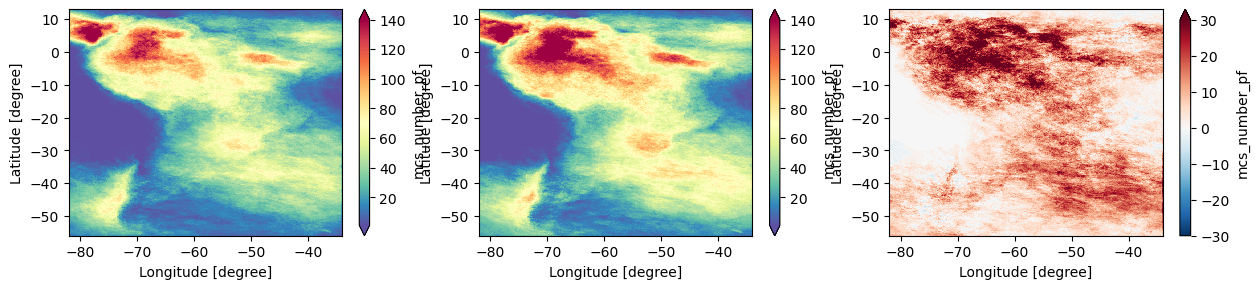

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=[15,3], dpi=100)
mcs_number_pf_all_idl.plot(vmin=1, vmax=140, cmap='Spectral_r', ax=ax[0])
mcs_number_pf_all_py.plot(vmin=1, vmax=140, cmap='Spectral_r', ax=ax[1])
mcs_number_pf_all_diff.plot(vmin=-30, vmax=30, cmap='RdBu_r', ax=ax[2])

In [25]:
def plot_map_3panels(dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-82, -34, -56, 13]
    lonv = list(np.arange(-180,180.1,10))
    latv = list(np.arange(-90,90.1,10))
    lonvals = mpl.ticker.FixedLocator(lonv)
    latvals = mpl.ticker.FixedLocator(latv)
    proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=[14,5.5], dpi=100)
    
    for pp in range(0,3):
        ax = plt.subplot(1, 3, pp+1, projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
#         ax.set_extent(map_extend, ccrs.Geodetic())
#         ax.add_feature(land, facecolor='lightgray')
#         ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
#         ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)

        gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5, zorder=10)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = lonvals
        gl.ylocator = latvals
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        if (pp != 0):
            gl.left_labels = False
        
        data = dataarray[pp]
#         Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        Zm = np.ma.masked_where(((np.isnan(data))), data)
        cmap = copy.copy(mpl.cm.get_cmap(cmaps[pp]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
#         cf1 = ax.contourf(lonarray[pp], latarray[pp], Zm, levels=levels[pp], norm=norm, cmap=cmaps[pp], transform=proj, zorder=2, extend='both')
#         norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=256)
#         cf1 = plt.contourf(lonarray[pp], latarray[pp], Zm, levels=levels[pp], norm=norm, cmap=cmaps[pp], transform=proj, zorder=2, extend='both')
        cf1 = ax.pcolormesh(lonarray, latarray, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
        ax.set_title(titles[pp], loc='left')
        cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[pp], pad=0.02, ticks=cbticks[pp], extend='both', aspect=30)
        if (oob_colors is not None) and (pp != 2):
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))
#         ax.set_aspect('auto', adjustable=None)

        # Terrain height
#         ctf = ax.contourf(lon_ter, lat_ter, ter_s, levels=levelshgt, \
#                          colors='lightgray', transform=proj, zorder=1)
        ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
                        colors='dimgray', linewidths=1, transform=proj, zorder=3)

    # Work around to make tight_layout work 
    fig.canvas.draw()
    fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [26]:
# dataarray = [totpcp_all_idl, totpcp_all_py, totpcp_all_diff]
# levelspcp = [0,0.2,0.5,1,1.5,2,3,4,6,8,12]
# levelsdiff = np.arange(-5,5.1,1)
# levels = [levelspcp, levelspcp, levelsdiff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmaps = [cmappcp,cmappcp,'RdBu']
# titles = [f'(a) Total Precipitation (IMERG)', f'(b) Total Precipitation (WRF)', f'(c) Difference (WRF-IMERG)']
# cblabels = ['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']
# cbticks = levels
# figname = f'{figdir}imerg_py_total_rainmap_annual.png'
# oob_colors = {'under':'white', 'over':'magenta'}
# fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

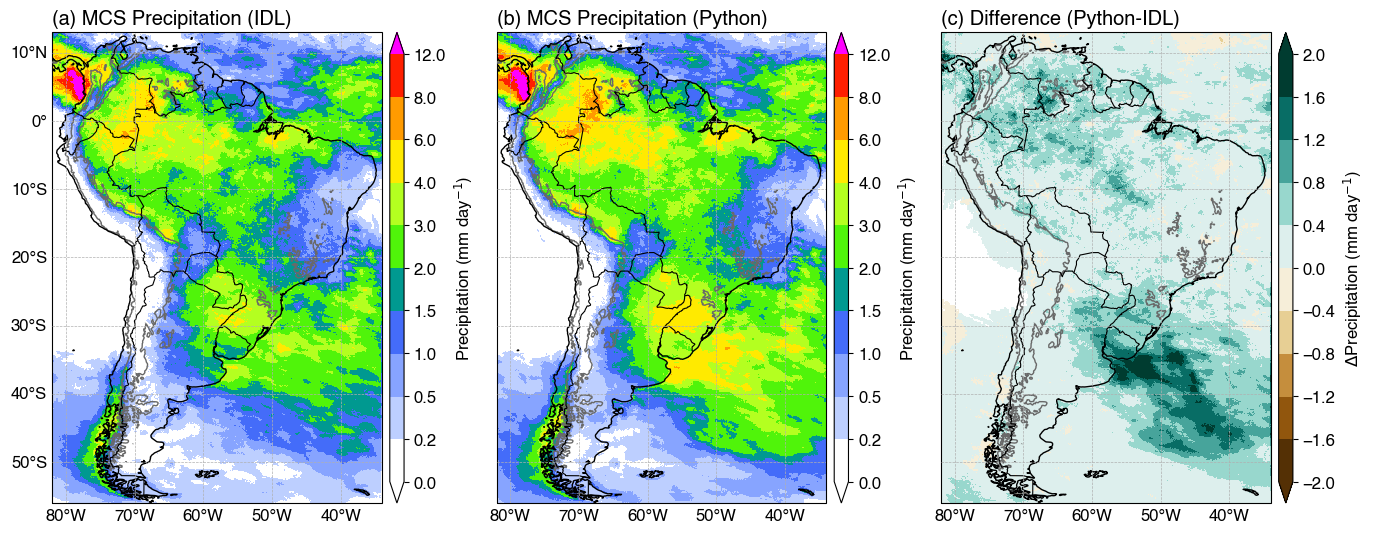

In [27]:
mcspcp_all_diff = np.ma.masked_where(mcspcp_all_diff == 0, mcspcp_all_diff)
dataarray = [mcspcp_all_idl, mcspcp_all_py, mcspcp_all_diff]
levelspcp = [0,0.2,0.5,1,1.5,2,3,4,6,8,12]
levelsdiff = np.arange(-2,2.1,0.4)
levels = [levelspcp, levelspcp, levelsdiff]
cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmaps = [cmappcp,cmappcp,'BrBG']
titles = [f'(a) MCS Precipitation (IDL)', f'(b) MCS Precipitation (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']
cbticks = levels
figname = f'{figdir}idl_python_mcs_rainmap_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

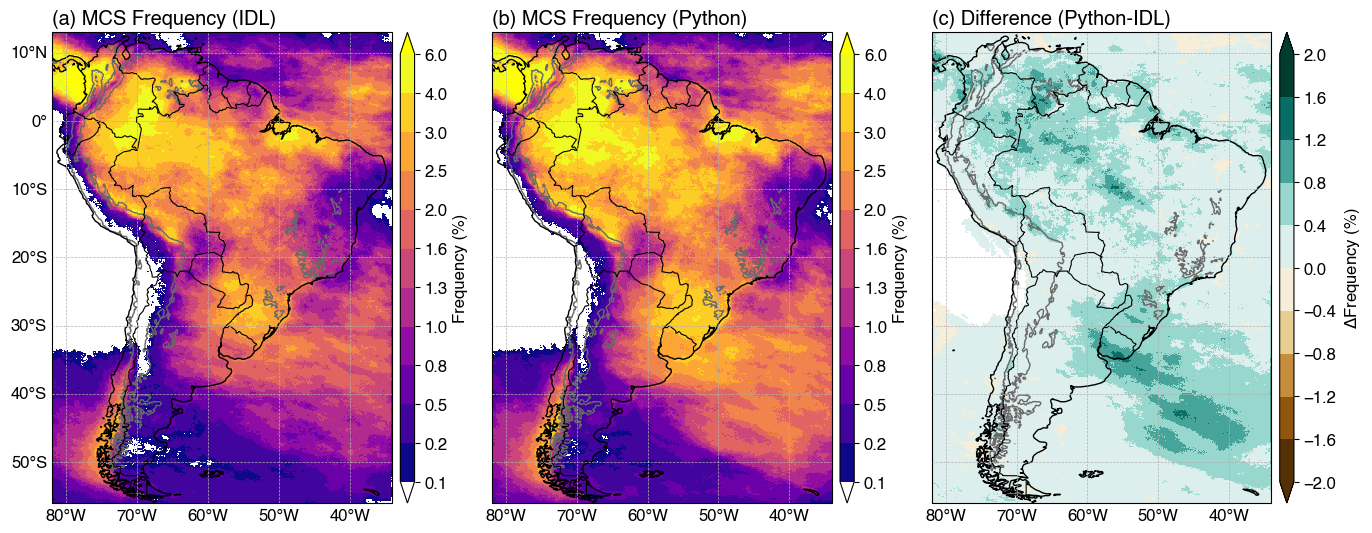

In [28]:
mcspcpfreq_all_diff = mcspcpfreq_all_py - mcspcpfreq_all_idl
mcspcpfreq_all_diff = np.ma.masked_where(mcspcpfreq_all_diff == 0, mcspcpfreq_all_diff)
dataarray = [mcspcpfreq_all_idl, mcspcpfreq_all_py, mcspcpfreq_all_diff]
levelsfreq = [0.1,0.2,0.5,0.8,1,1.3,1.6,2,2.5,3,4,6]
levelsdiff = np.arange(-2,2.1,0.4)
levels = [levelsfreq, levelsfreq, levelsdiff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapfreq = 'plasma'
cmaps = [cmapfreq,cmapfreq,'BrBG']
titles = [f'(a) MCS Frequency (IDL)', f'(b) MCS Frequency (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Frequency (%)','Frequency (%)',r'$\Delta$'+'Frequency (%)']
cbticks = levels
figname = f'{figdir}idl_python_mcs_rainfreq_annual.png'
oob_colors = {'under':'white', 'over':'yellow'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

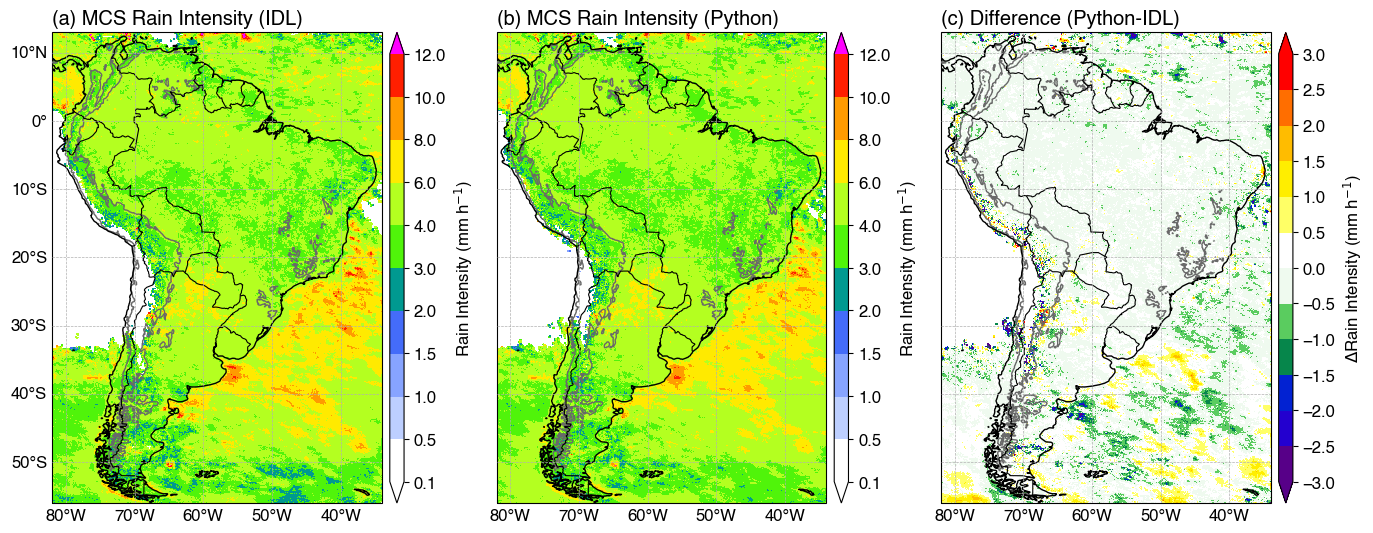

In [29]:
min_nmcs = 3
mcspcpintensity_all_diff = mcspcpintensity_all_py - mcspcpintensity_all_idl
dataarray = [mcspcpintensity_all_idl.where(mcs_number_pf_all_idl > min_nmcs), 
             mcspcpintensity_all_py.where(mcs_number_pf_all_py > min_nmcs),
             mcspcpintensity_all_diff.where(mcs_number_pf_all_py > min_nmcs)]
levelspcp = [0.1,0.5,1,1.5,2,3,4,6,8,10,12]
levelsdiff = np.arange(-3,3.1,0.5)
levels = [levelspcp, levelspcp, levelsdiff]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmapfreq = 'plasma'
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MCS Rain Intensity (IDL)', f'(b) MCS Rain Intensity (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Rain Intensity (mm h$^{-1}$)','Rain Intensity (mm h$^{-1}$)',r'$\Delta$'+'Rain Intensity (mm h$^{-1}$)']
cbticks = levels
figname = f'{figdir}idl_python_mcs_rainintensity_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

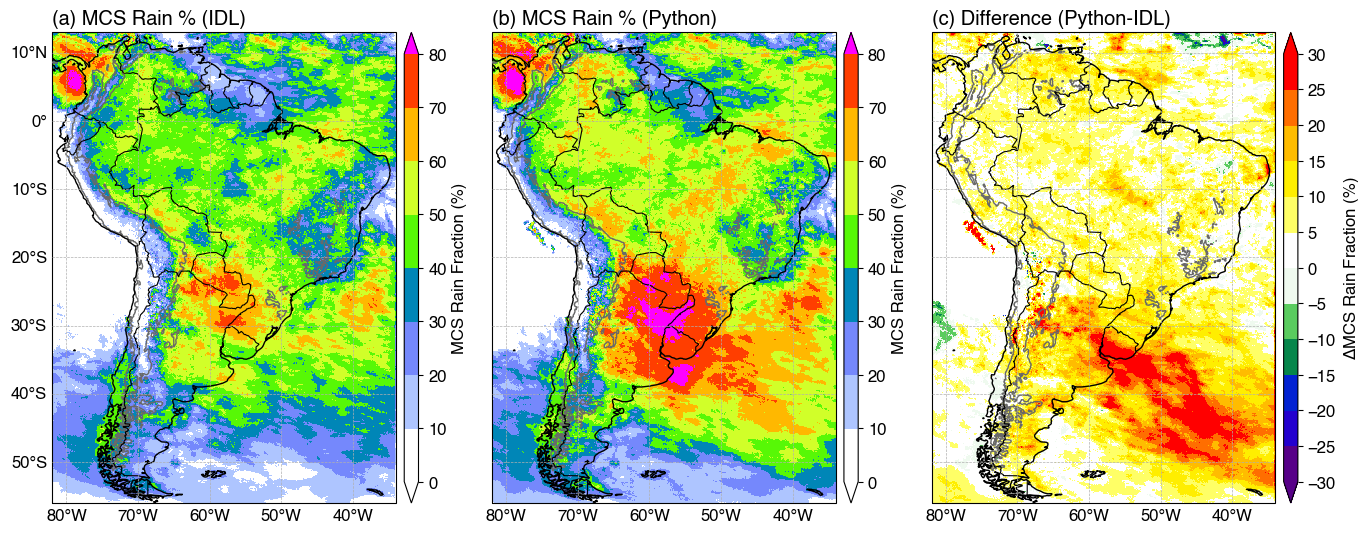

In [30]:
mcspcpfrac_all_diff = mcspcpfrac_all_py - mcspcpfrac_all_idl
mcspcpfrac_all_diff = np.ma.masked_where(mcspcpfrac_all_diff == 0, mcspcpfrac_all_diff)
dataarray = [mcspcpfrac_all_idl, mcspcpfrac_all_py, mcspcpfrac_all_diff]
levelsfrac = np.arange(0,81,10)
levelsdiff = np.arange(-30,30.1,5)
levels = [levelsfrac, levelsfrac, levelsdiff]
cmapfrac = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
cmapfrac = truncate_colormap(cmap, 0.0, 0.98)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [cmapfrac,cmapfrac,cmapdiff]
titles = [f'(a) MCS Rain % (IDL)', f'(b) MCS Rain % (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['MCS Rain Fraction (%)','MCS Rain Fraction (%)',r'$\Delta$'+'MCS Rain Fraction (%)']
cbticks = levels
figname = f'{figdir}idl_python_mcs_rainfrac_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

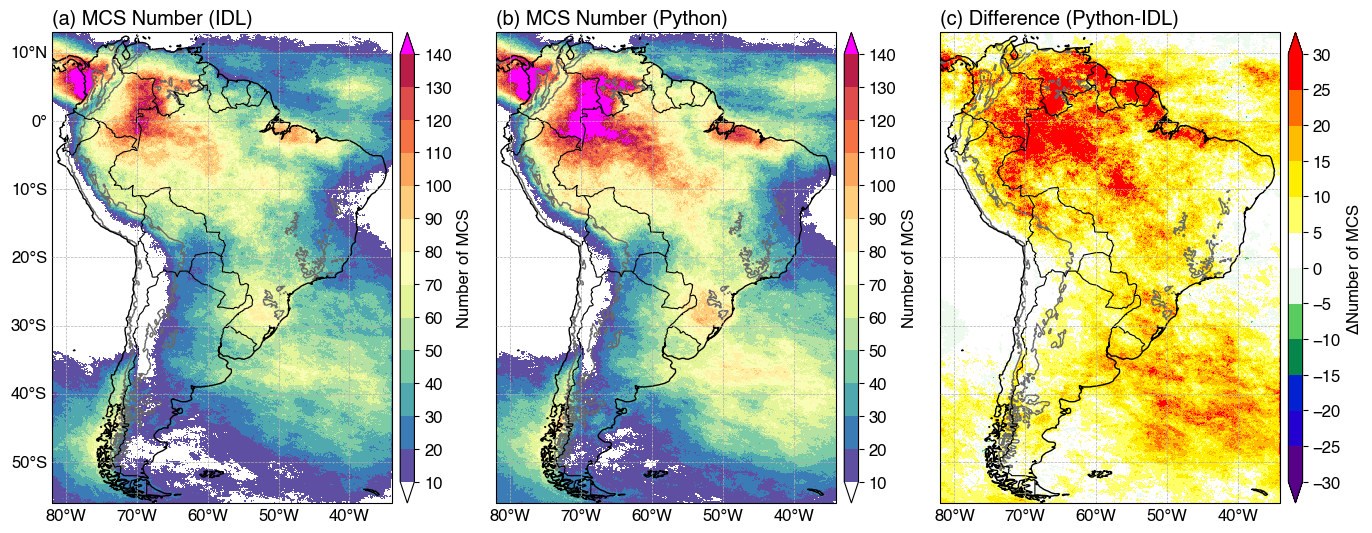

In [31]:
mcs_number_pf_all_diff = mcs_number_pf_all_py - mcs_number_pf_all_idl
mcs_number_pf_all_diff = np.ma.masked_where(mcs_number_pf_all_diff == 0, mcs_number_pf_all_diff)
dataarray = [mcs_number_pf_all_idl, mcs_number_pf_all_py, mcs_number_pf_all_diff]
# levels = [3,5,10,15,20,25,30,40,60,80,100,130,160]
levels = np.arange(10, 140.1, 10)
levelsdiff = np.arange(-30, 30.1, 5)
# levelsdiff = [-70,-50,-40,-30,-20,-10,0,10,20,30,40,50,70]
levels = [levels, levels, levelsdiff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MCS Number (IDL)', f'(b) MCS Number (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}idl_python_mcs_number_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

In [32]:
# # Plot seasonal MCS rainmap
# for ii in seasons:
#     print(ii)
#     mcspcp_season_diff = mcspcp_season_py - mcspcp_season_idl
#     dataarray = [mcspcp_season_idl.sel(season=ii), mcspcp_season_py.sel(season=ii), mcspcp_season_diff.sel(season=ii)]
#     levels = [0,0.2,0.5,1,1.5,2,3,4,6,8,12]
#     levelsdiff = np.arange(-5,5.1,1)
#     levels = [levels, levels, levelsdiff]
#     cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
#     cmaps = [cmap,cmap,'BrBG']
#     titles = [f'(a) {ii} MCS Precipitation (IDL)', f'(b) {ii} MCS Precipitation (Python)', f'(c) {ii} Difference (Python-IDL)']
#     cblabels = ['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']
#     cbticks = levels
#     figname = f'{figdir}imerg_py_mcs_rainmap_{ii}.png'
#     oob_colors = {'under':'white', 'over':'magenta'}
#     fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
#     plt.close(fig)

In [33]:
# for ii in seasons:
#     print(ii)
#     mcspcpfreq_season_diff = mcspcpfreq_season_py - mcspcpfreq_season_idl
#     dataarray = [mcspcpfreq_season_idl.sel(season=ii), mcspcpfreq_season_py.sel(season=ii), mcspcpfreq_season_diff.sel(season=ii)]
#     levelsfreq = [0.2,0.5,0.8,1,1.3,1.6,2,2.5,3,4,6,8]
#     levelsdiff = np.arange(-5,5.1,1)
#     levels = [levelsfreq, levelsfreq, levelsdiff]
#     # cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
#     cmapfreq = 'plasma'
#     cmaps = [cmapfreq,cmapfreq,'BrBG']
#     titles = [f'(a) {ii} MCS Frequency (IDL)', f'(b) {ii} MCS Frequency (Python)', f'(c) {ii} Difference (Python-IDL)']
#     cblabels = ['Frequency (%)','Frequency (%)',r'$\Delta$'+'Frequency (%)']
#     cbticks = levels
#     figname = f'{figdir}imerg_py_mcs_rainfreq_{ii}.png'
#     oob_colors = {'under':'white', 'over':'yellow'}
#     fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
#     plt.close(fig)

In [34]:
# for ii in seasons:
#     print(ii)
#     min_nmcs = 2
#     mcspcpintensity_season_diff = mcspcpintensity_season_py - mcspcpintensity_season_idl
#     dataarray = [mcspcpintensity_season_idl.sel(season=ii).where(mcs_number_pf_season_idl.sel(season=ii) > min_nmcs), 
#                  mcspcpintensity_season_py.sel(season=ii).where(mcs_number_pf_season_py.sel(season=ii) > min_nmcs),
#                  mcspcpintensity_season_diff.sel(season=ii).where(mcs_number_pf_season_py.sel(season=ii) > min_nmcs)]
#     levelspcp = [0.1,0.5,1,2,3,4,6,8,10,15]
#     levelsdiff = np.arange(-8,8.1,1)
#     levels = [levelspcp, levelspcp, levelsdiff]
#     cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
#     # cmapfreq = 'plasma'
#     cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
#     cmaps = [cmap,cmap,cmapdiff]
#     titles = [f'(a) {ii} MCS Rain Intensity (IDL)', f'(b) {ii} MCS Rain Intensity (Python)', f'(c) {ii} Difference (Python-IDL)']
#     cblabels = ['Rain Intensity (mm h$^{-1}$)','Rain Intensity (mm h$^{-1}$)',r'$\Delta$'+'Rain Intensity (mm h$^{-1}$)']
#     cbticks = levels
#     figname = f'{figdir}imerg_py_mcs_rainintensity_{ii}.png'
#     oob_colors = {'under':'white', 'over':'magenta'}
#     fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
#     plt.close(fig)

In [35]:
# for ii in seasons:
#     print(ii)
#     mcspcpfrac_season_diff = mcspcpfrac_season_py - mcspcpfrac_season_idl
#     dataarray = [mcspcpfrac_season_idl.sel(season=ii), mcspcpfrac_season_py.sel(season=ii), mcspcpfrac_season_diff.sel(season=ii)]
#     levelsfrac = np.arange(0,81,10)
#     levelsdiff = np.arange(-50,50.1,10)
#     levels = [levelsfrac, levelsfrac, levelsdiff]
#     cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
#     cmap = truncate_colormap(cmap, 0.0, 0.95)
#     cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
#     cmaps = [cmapfrac,cmapfrac,cmapdiff]
#     titles = [f'(a) {ii} MCS Rain % (IDL)', f'(b) {ii} MCS Rain % (Python)', f'(c) {ii} Difference (Python-IDL)']
#     cblabels = ['MCS Rain Fraction (%)','MCS Rain Fraction (%)',r'$\Delta$'+'MCS Rain Fraction (%)']
#     cbticks = levels
#     figname = f'{figdir}imerg_py_mcs_rainfrac_{ii}.png'
#     oob_colors = {'under':'white', 'over':'magenta'}
#     fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
#     plt.close(fig)

In [36]:
# for ii in seasons:
#     print(ii)
#     mcs_number_pf_season_diff = mcs_number_pf_season_py - mcs_number_pf_season_idl
#     dataarray = [mcs_number_pf_season_idl.sel(season=ii), mcs_number_pf_season_py.sel(season=ii), mcs_number_pf_season_diff.sel(season=ii)]
#     levels = [2,4,7,10,13,16,20,25,30,35,40]
#     # levelsdiff = np.arange(-80,80.1,10)
#     levelsdiff = [-30,-20,-15,-10,-5,0,5,10,15,20,30]
#     levels = [levels, levels, levelsdiff]
#     # cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
#     cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
#     cmap = truncate_colormap(cmap, 0.0, 0.95)
#     cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
#     cmaps = [cmap,cmap,cmapdiff]
#     titles = [f'(a) {ii} MCS Number (IDL)', f'(b) {ii} MCS Number (Python)', f'(c) {ii} Difference (Python-IDL)']
#     cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
#     cbticks = levels
#     figname = f'{figdir}imerg_py_mcs_number_{ii} .png'
#     oob_colors = {'under':'white', 'over':'magenta'}
#     fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
#     plt.close(fig)